In [5]:
#format the book
%matplotlib inline
import book_format
book_format.load_style(name='/custom3.css')

# Nonlinear Filtering

## The Problem with Nonlinearity

* All of the equations of the classic Kalman filter are linear, so the filter can only handle linear problems. 

![](spring_m.jpg "Weit on Spring")

* Suppose we wanted to track the motion of a weight on a spring where $F=0$. The equation for the motion with $m$ being the mass, $k$ the spring constant, and $c$ the damping force is 

$$m\frac{d^2x}{dt^2} + c\frac{dx}{dt} +kx = 0$$,

which is a second order differential equation. It is not possible to write a linear equation for this equation, and therefore we cannot even formulate a design for the Kalman filter. 

* It is almost true to state that the only equation the entire mathematical community know how to solve is $\mathbf{Ax}=\mathbf{b}$. 

* One of solutions: linearize the problem, turning it into a set of linear equations.
    * It's an approximation, so the answers are approximate. 
    * Linearizing a nonlinear problem gives inexact answers, and in a recursive algorithm like a Kalman filter tracking system these small errors can sometimes reinforce each other at each step, quickly causing the algorithm to spit out nonsense. 
    * There is not one obvious, correct, mathematically optimal solution anymore. We will forever be battling filters that *diverge*, that is, filters whose numerical errors overwhelm the solution. 

## An Intuitive Look at the Problem

* Consider a tracking problem where we get the **range** and **bearing** to a target, and we want to track its position.
* Suppose the distance is 50km, and the reported angle is 90$^\circ$. 
* Assume that the errors in both range and angle are distributed in a Gaussian manner. 
    * Each time we take a reading the range will be $50\pm\sigma_{range}$ and the angle will be $90\pm\sigma_{angle}$. 
* What is the expected value of the position?
    * Intuition: since the mean of the range will be 50km, and the mean of the angle will be 90$^\circ$, so the answer will be x=0 km, y=90 km.
* Varify the intuition
    * Here are 300 points with a normal distribution of the distance of 0.4 km, and the angle having a normal distribution of 0.35 radians. 
    * Compute the average of the all of the positions, and display it as a star. Our intuition is displayed with a triangle.

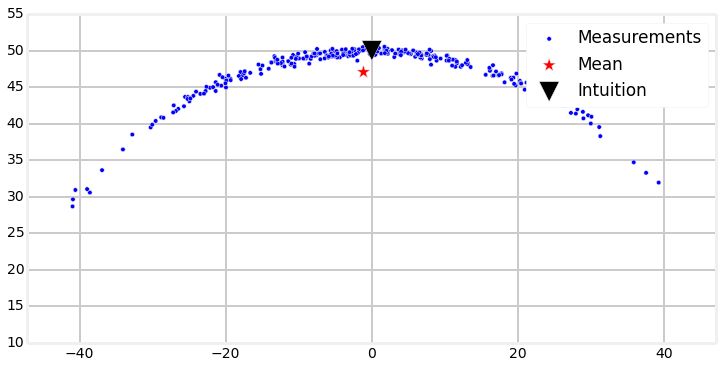

In [6]:
from numpy.random import randn
import matplotlib.pyplot as plt
import math

xs, ys = [], []
N = 300
for i in range (N):
    a = math.pi / 2. + (randn() * 0.35)
    r = 50.0         + (randn() * 0.4)
    xs.append(r*math.cos(a))
    ys.append(r*math.sin(a))

plt.scatter(xs, ys, label='Measurements')
plt.scatter(sum(xs)/N, sum(ys)/N, c='r', marker='*', s=200, label='Mean')
plt.scatter(0, 50, c='k', marker='v', s=400, label='Intuition')
plt.axis('equal')
plt.legend(scatterpoints=1)
plt.show()

* We can see that the intuition failed us
    * The nonlinearity of the problem forced all of the errors to be biased in one direction. This bias, over many iterations, can cause the Kalman filter to diverge.

## The Effect of Nonlinear Functions on Gaussians

* The mathematics of the Kalman filter is beautiful in part due to the Gaussian equation being so special. 
    * When we add and multiply it using linear algebra we get another Gaussian equation
* At time $k$, the Kalman Filter passes the covariances through the process function to get the new covariance. The process function is linear, so the output is always another Gaussian.  
    * Example: Pass an arbitrary Gaussian through the function $f(x) = 2x + 1$ and plot the result. 


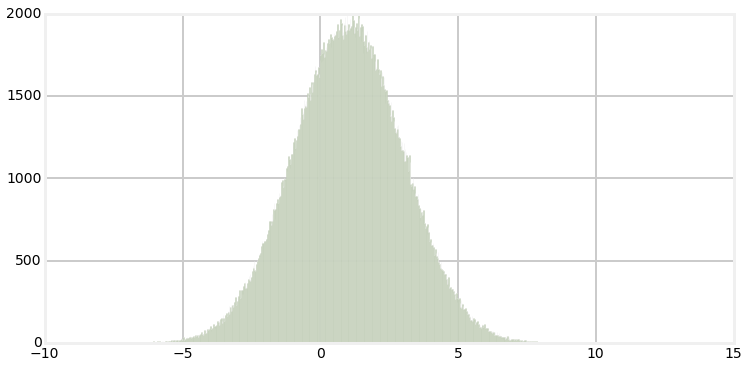

In [3]:
import numpy as np
from numpy.random import normal

data = normal(loc=0.0, scale=1, size=500000)
ys = 2*data + 1

plt.hist(ys,1000)
plt.show()

This is an unsurprising result. The result of passing the Gaussian through $f(x)=2x+1$ is another Gaussian centered around 1. Let's look at the input, transfer function, and output at once.

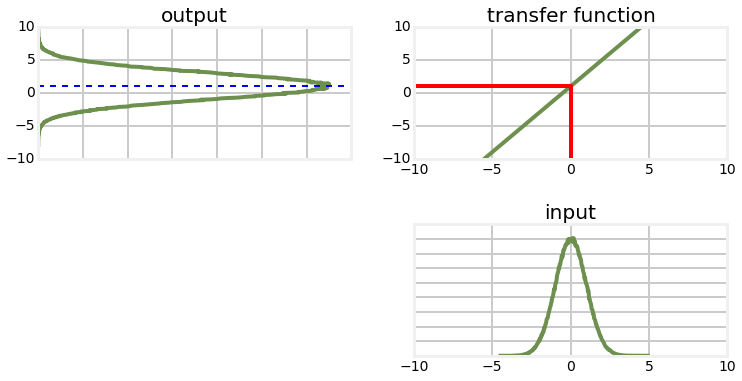

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def plot_transfer_func(data, f, lims, num_bins=1000):
    ys = f(data)
        
    h = np.histogram(ys, num_bins, density=False)
   
    #plot output
    plt.subplot(2,2,1)
    plt.plot(h[0], h[1][1:], lw=4)
    plt.ylim(lims)
    plt.gca().xaxis.set_ticklabels([])
    plt.title('output')

    plt.axhline(np.mean(ys), ls='--', lw=2)

    # plot transfer function
    plt.subplot(2,2,2)
    x = np.arange(lims[0], lims[1],0.1)
    y = f(x)
    plt.plot (x,y)
    isct = f(0)
    plt.plot([0,0,lims[0]],[lims[0],isct,isct],c='r')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.title('transfer function')

    # plot input
    h = np.histogram(data, num_bins, density=True)

    plt.subplot(2,2,4)
    plt.plot(h[1][1:], h[0], lw=4)
    plt.xlim(lims)
    plt.gca().yaxis.set_ticklabels([])
    plt.title('input')

    plt.show()

def g(x):
    return 2*x+1

plot_transfer_func (data, g, lims=(-10,10), num_bins=300)

* The plot labeled 'input' is the histogram of the original data. 
* The histogram is passed through the transfer function $f(x)=2x+1$ which is displayed in the chart to the upper right.
    * The red lines shows how one value, $x=0$ is passed through the function. 
* Each value from input is passed through in the same way to the output function on the left.
* For the output take the average of all the points, and draw the results with the dotted blue line. 
* The output looks like a Gaussian, and is in fact a Gaussian. 
    * The variance in the output is larger than the variance in the input, and the mean has been shifted from 0 to 1, which is what we would expect given the transfer function $f(x)=2x+1$


* Unfortunately Gaussians are not closed under an arbitrary nonlinear function. 
    * Now let's look at a nonlinear function $f(x)=cos(4(x/2+0.7))-1.3x$,  and see how it affects the probability distribution

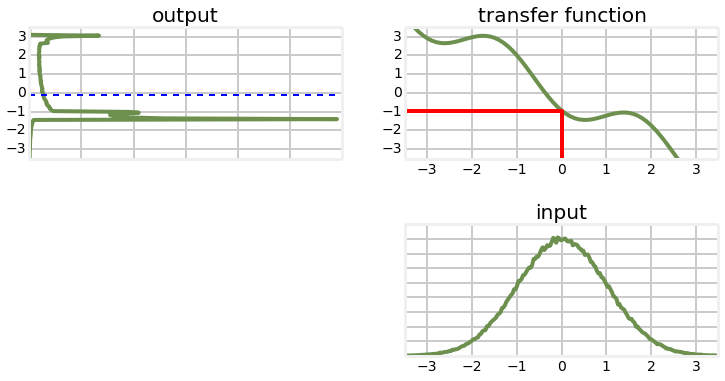

In [8]:
from numpy.random import normal
import numpy as np

data = normal(loc=0.0, scale=1, size=500000)

def g(x):
    return (np.cos(4*(x/2+0.7)))-1.3*x

plot_transfer_func (data, g, lims=(-3.5,3.5), num_bins=300)

Another nonlinear function  $f(x)=cos(4(x/2+0.7))sin(0.3x)-1.6x$

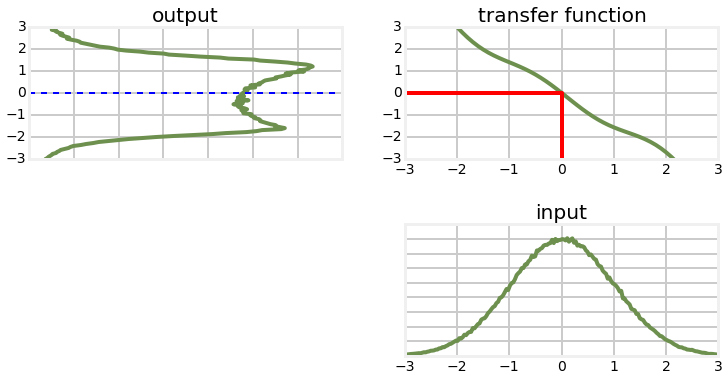

In [5]:
def g(x):
    return (np.cos(4*(x/2+0.7)))*np.sin(0.3*x)-1.6*x

plot_transfer_func (data, g, lims=(-3,3), num_bins=300)

* The transfer function looks "fairly" linear - it is pretty close to a straight line, but the probability distribution of the output is completely different from a Gaussian.  

* All of the equations of the Kalman filter assume that a Gaussian passed through the process function results in another Gaussian. If this is not true then all of the assumptions and guarantees of the Kalman filter do not hold. 

Let's look at what happens when we pass the output back through the function again, simulating the next step of the Kalman filter.

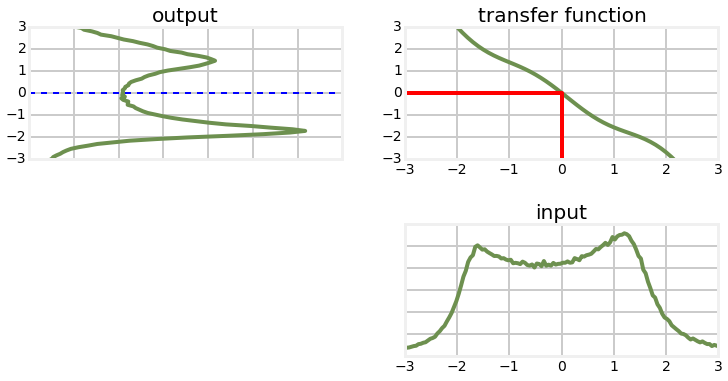

In [6]:
y=g(data)
plot_transfer_func (y, g, lims=(-3,3), num_bins=300)

* The probability function is further distorted from the original Gaussian. 
* However, the graph is still somewhat symmetric around x=0, let's see what the mean is.

In [7]:
print ('input  mean, variance: %.4f, %.4f'% (np.average(data), np.std(data)**2))
print ('output mean, variance: %.4f, %.4f'% (np.average(y), np.std(y)**2))

input  mean, variance: -0.0017, 0.9984
output mean, variance: -0.0251, 2.2377


Compare that to the linear function that passes through (-2,3) and (2,-3), which is very close to the nonlinear function we have plotted.

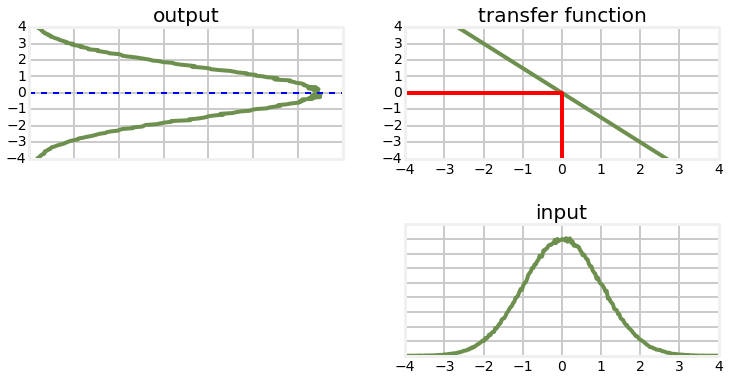

output mean, variance: 0.0025, 2.2465


In [8]:
def h(x): return -1.5*x
plot_transfer_func (data, h, lims=(-4,4), num_bins=300)
out = h(data)
print ('output mean, variance: %.4f, %.4f'% (np.average(out), np.std(out)**2))

* Although the shapes of the output are very different, the mean and variance of each are similar.
* This may lead us to reasoning that perhaps we can ignore this problem if the nonlinear equation is 'close to' linear.
* To test that, we can iterate several times and then compare the results.

In [9]:
out = h(data)
out2 = g(data)

for i in range(10):
    out = h(out)
    out2 = g(out2)
print ('linear    output mean, variance: %.4f, %.4f' % 
       (np.average(out), np.std(out)**2))
print ('nonlinear output mean, variance: %.4f, %.4f' % 
       (np.average(out2), np.std(out2)**2))

linear    output mean, variance: 0.1464, 7470.2300
nonlinear output mean, variance: -1.5418, 26163.4005


* Unfortunately the nonlinear version is not stable. 
    * It drifts significantly from the mean of 0, and the variance is half an order of magnitude larger. 

## A 2D Example

* Think about tracking an aircraft with radar, which may have a covariance that looks like this:

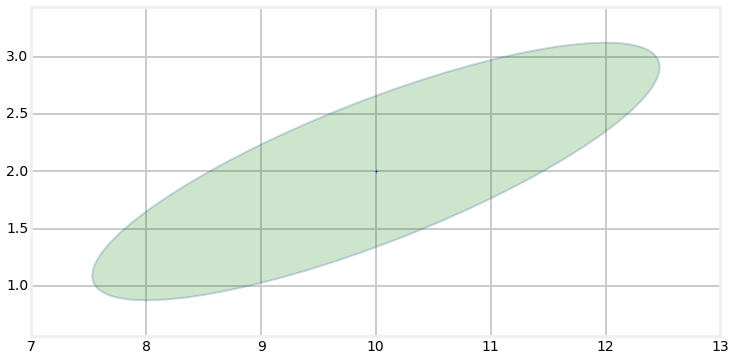

In [10]:
import stats
import numpy as np
P = np.array([[6, 2.5], [2.5, .6]])
stats.plot_covariance_ellipse((10, 2), P,  facecolor='g', alpha=0.2)

So what happens when we try to linearize this problem?
* The radar gives a range to the aircraft. 
* Suppose the radar is directly under the aircraft (x=10) and the next measurement states that the aircraft is 3 miles away (y=3). 
    * The positions that could match that measurement form a circle with radius 3 miles.

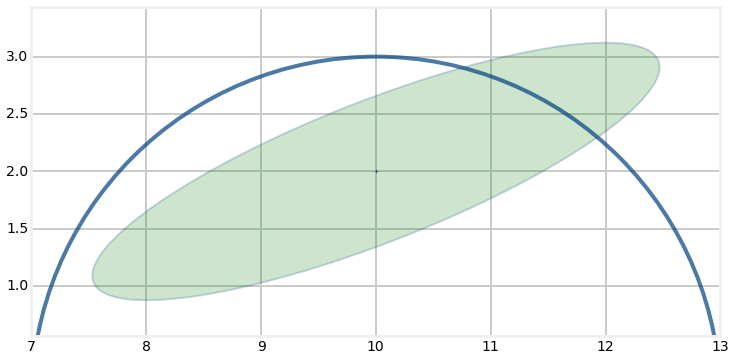

In [11]:
from matplotlib.patches import Ellipse
circle1=plt.Circle((10,0),3,color='#004080',fill=False,linewidth=4, alpha=.7)
ax = plt.gca()
ax.add_artist(circle1)
plt.xlim(0,10)
plt.ylim(0,3)

stats.plot_covariance_ellipse((10, 2), P,  facecolor='g', alpha=0.2)

* The probable position of the aircraft is somewhere near x=11.4, y=2.7 because that is where the covariance ellipse and range measurement overlap. 
* But the range measurement is nonlinear so we have to linearize it.
    * Linearize at the last position of the aircraft - (10,2). 
    * At x=10 the range measurement has y=3, and so we linearize at that point.

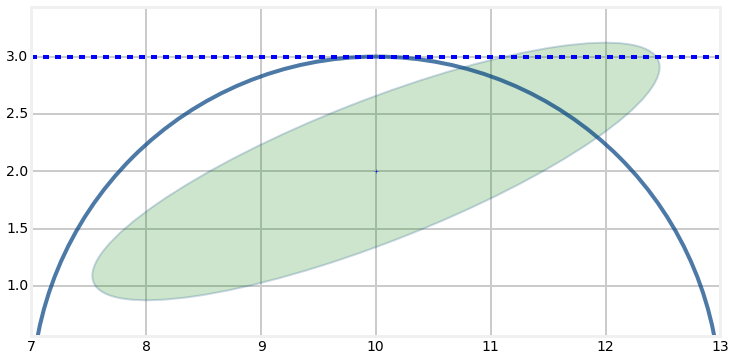

In [12]:
from matplotlib.patches import Ellipse
circle1=plt.Circle((10,0),3,color='#004080',fill=False,linewidth=4, alpha=.7)
ax = plt.gca()
ax.add_artist(circle1)
plt.xlim(0,10)
plt.ylim(0,3)
plt.axhline(3, ls='--')
stats.plot_covariance_ellipse((10, 2), P,  facecolor='g', alpha=0.2)

* Now we have a linear representation of the problem (literally a straight line) which we can solve.
* Unfortunately you can see that the intersection of the line and the covariance ellipse is a long way from the actual aircraft position.

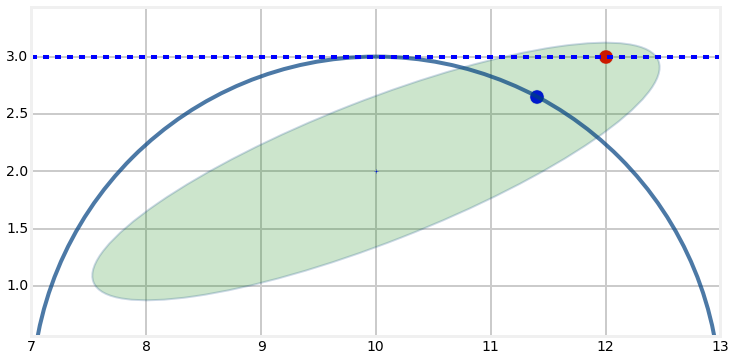

In [13]:
from matplotlib.patches import Ellipse
circle1=plt.Circle((10,0),3,color='#004080',fill=False,linewidth=4, alpha=.7)
ax = plt.gca()
ax.add_artist(circle1)
plt.xlim(0,10)
plt.ylim(0,3)
plt.axhline(3, ls='--')
stats.plot_covariance_ellipse((10, 2), P,  facecolor='g', alpha=0.2)
plt.scatter([11.4], [2.65],s=200)
plt.scatter([12],[3], c='r', s=200)
plt.show()

* That sort of error often leads to disastrous results.
    * In the next innovation of the filter that very bad estimate will be used to linearize the next radar measurement, so the next estimate is likely to be markedly worse than this one. 
    * After only a few iterations the Kalman filter will diverge, and start producing results that have no correspondence to reality.
* You will always be battling divergence when working with nonlinear systems.